# Algorytm symulowanej bifurkacji

Jest to heurystyczny algorytm zainspirowany fizyką. Intuicyjnie, możemy o nim myśleć jako zakodowaniu naszego problemu uoptymalizacjyjnego jako pewien układ dynamiczny opisany rówaniami różniczkowymi. Te równania śledzą położenie $x$ i pęd $y$ pewnej grupy cząsteczek. Rozwiązując te równania różniczkowe numerycznie (np. metodą symplektyczną Eulera) otrzymujemy rozwiązanie oryginalnego problemu. Dla naszych zastosowań możemy go traktować jako czarną skrzynkę.

Zostaną Pokazane dwie wersje tego algorytmu które nieznacznie się od siebie różnią, balistyczna symulowana bifurkacja i dyskretna symulowana bifurkacja. Te algorytmy w bardzo naturalny sposób się zrównoleglają i taka wersja będzie od początku zaimplementowana.

## Balistyczna Symulowana Bifurkacja

W każdym kroku $t_k$ "pozycja" $x(t_k)$ i "pęd" $y(t_k)$ są aktualizowane za pomocą następujących wzorów:

$$
y_i(t_{k+1}) = y_i(t_k) + \{-[a_0 - a(t_k)]x_i(t_k) + c_0 \sum_{j=1}^N J_{i,j}x_j(t_k) \}\Delta_t
$$
$$
x_i(t_{k+1}) = x_i(t_k) + a_0 y_i(t_{k+1})\Delta_t
$$

Ponadto przyjmujemy tzw. "nieelastyczną scianę" dla $\vert x \vert = 1$. Oznacza to, że jeżeli w dowolnym momęcie algorytmu $\vert x \vert > 1$ to obcinamy $x$ do odpowiedniej wartości (-1 lub 1) i ustawiamy $y = 0$. Można o tym myśleć jak o cząsteczce uderzającej w ścianie i się do niej przyklejającą. Matematycznie możemy tą operacje wyrazić funkcją $\text{Wall}(x, y)$.

$$
\text{Wall}(x, y) = \left\{
                            \begin{array}{ll}
                            (\text{sign}(x), 0), & \text{jeżeli } \vert x \vert > 1 \\
                            (x, y) & \text{w pozostałych przypadkach}\\
                            \end{array}
                            \right.
$$


Na końcu obliczeń należy zbinaryzować "pozycję" by otrzymać stan Isinga w rozwiązaniu. Użyjemy do tego funkcji znaku $\text{sign}(x)$. Dla przypomnienia:

$$
\text{sign}(x) = \left\{
                            \begin{array}{ll}
                            1, & \text{jeżeli } x > 0 \\
                            0, & \text{jeżeli } x = 0\\
                            -1, & \text{jeżeli } x < 0\\
                            \end{array}
                            \right.
$$


## Pseudokod

Tak jak poprzednio jako $T$ przyjmujemy ilość kroków którą zadaliśmy algorytmowi.

1. Zainicjalizuj $x(0) = 0$, losowy wektor $y(0) \in \mathcal{U}(-0.1, 0.1)$, parametry $a_0$, $c_0$, $\Delta_t$ oraz funkcję $a(t_k)$
2. For $t_{k} \in [0, \ldots, T-1]$  
    1. Policz $y(t_{k+1})$
    2. Policz $x(t_{k+1})$
    3. $\text{Wall}(x, y)$
3. Zbinaryzuj stan końcowy $x(t_T)$
4. Zwróc zbinaryzowany stan i odpowiadającą mu energię

WIP

In [3]:
# Implementacja Balistycznej Symulowanej Bifurkacji

import numpy as np

from math import sqrt
from typing import Optional
from tqdm import tqdm

from funkcje_pomocnicze import calculate_energy_matrix

def wall(x: np.ndarray, y: np.ndarray):
    mask = np.abs(x) > 1
    x[mask] = np.sign(x[mask])
    y[mask] = 0
    return x, y


def balistic_simulated_bifurcation(J, h, num_steps, time_step, num_trajectories: int, 
                                   a_0: Optional[float] = None, c_0_scaling: Optional[float] = None):
    if a_0 is None:
        a_0 = 1

    N, _ = J.shape
    mean_J = np.sqrt(np.sum(np.square(J)) / (N * (N - 1)) )
    c_0 = 0.5 / (mean_J * sqrt(N))

    if c_0_scaling is not None:
        c_0 *= c_0_scaling


    a = np.linspace(0, a_0, num=num_steps)

    x = np.zeros((N, num_trajectories))
    y = np.random.uniform(-0.1, 0.1, (N, num_trajectories))


    for t in tqdm(range(num_steps), desc="Symulowana Bifurkacja"):
        y += (-1 * (a_0 - a[t]) * x + c_0 * (J @ x + h.reshape((N, 1)))) * time_step  # y(t+1); x(t), x(t)
        x += a_0 * y * time_step # x(t + 1); y(t+1)

        x, y = wall(x, y)

    x = np.sign(x)
    return x, calculate_energy_matrix(J, h, x)



Symulowana Bifurkacja: 100%|██████████| 200/200 [00:00<00:00, 2271.69it/s]


Otrzymana energia: -467.0
Stan podstawowy: -469.0
Luka energetyczna: 0.21%


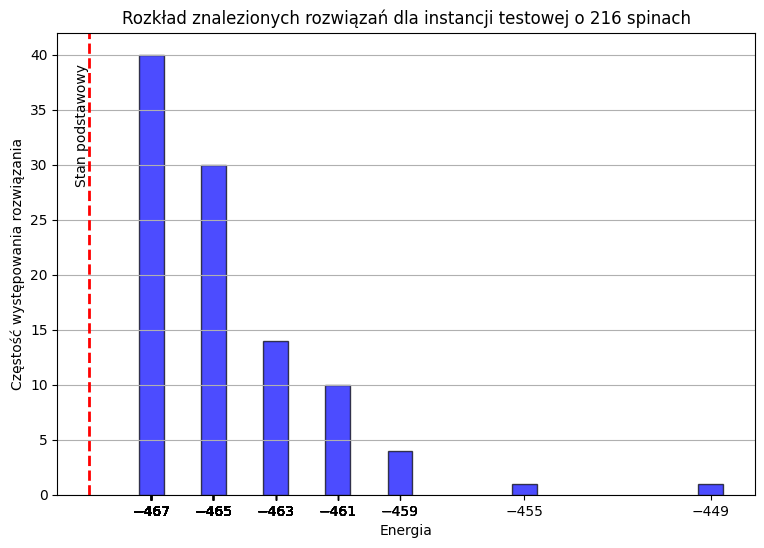

In [58]:
# Test na małym przykładzie z 216 spinami
# Balistyczna symulowana Bifurkacja

import numpy as np
import matplotlib.pyplot as plt
from funkcje_pomocnicze import read_instance, test_pegasus

J, h = read_instance(test_pegasus.path, convention="minus_half")

states, energies = balistic_simulated_bifurcation(J, h, num_steps=200, time_step=0.25, num_trajectories=100, a_0=1, c_0_scaling=0.7)

print(f"Otrzymana energia: {min(energies)}")
print(f"Stan podstawowy: {test_pegasus.best_energy}")
print(f"Luka energetyczna: {((test_pegasus.best_energy - min(energies))/(2 * test_pegasus.best_energy) * 100):.2f}%")

unique_values, counts = np.unique(energies, return_counts=True)


plt.figure(figsize=(9, 6))
plt.bar(unique_values, counts, color='blue', edgecolor='black', alpha=0.7)
plt.xticks(energies)
plt.axvline(x=test_pegasus.best_energy, color='red', linestyle='--', linewidth=2)
plt.text(test_pegasus.best_energy, plt.ylim()[1]*0.8, 'Stan podstawowy', color='black', rotation=90,
         verticalalignment='center', horizontalalignment='right')

plt.xlabel("Energia")
plt.ylabel("Częstość występowania rozwiązania")
plt.title("Rozkład znalezionych rozwiązań dla instancji testowej o 216 spinach")
plt.grid(axis="y")
plt.show()


## Dyskretna Symulowana Bifurkacja

Jest podobna do balistycznej, jedyna różnica jest taka, że podczas update parametru $y$ część $J_{i,j}x_j(t_k)$ zastępujemy na $J_{i,j}\text{sign}(x_j(t_k))$, gdzie $\text{sign}$ jest funkcją znaku. 

Wtedy równania które opisują ewolucję parametrów $x$ i $y$ wyglądają następująco:

$$
y_i(t_{k+1}) = y_i(t_k) + \{-[a_0 - a(t_k)]x_i(t_k) + c_0 \sum_{j=1}^N J_{i,j}\text{sign}(x_j(t_k)) \}\Delta_t
$$
$$
x_i(t_{k+1}) = x_i(t_k) + a_0 y_i(t_{k+1})\Delta_t
$$

Reszta algorytmu pozostaje bez zmian.


In [6]:
# Implementacja dyskretnej Symulowanej Bifurkacji
import numpy as np

from math import sqrt
from typing import Optional
from tqdm import tqdm

from funkcje_pomocnicze import calculate_energy_matrix


def wall(x: np.ndarray, y: np.ndarray):
    mask = np.abs(x) > 1
    x[mask] = np.sign(x[mask])
    y[mask] = 0
    return x, y


def discrete_simulated_bifurcation(J, h, num_steps, time_step, num_trajectories: int, 
                                   a_0: Optional[float] = None, c_0_scaling: Optional[float] = None):
    if a_0 is None:
        a_0 = 1

    N, _ = J.shape
    mean_J = np.sqrt(np.sum(np.square(J)) / (N * (N - 1)) )
    c_0 = 0.5 / (mean_J * sqrt(N))

    if c_0_scaling is not None:
        c_0 *= c_0_scaling
        
    a = np.linspace(0, a_0, num=num_steps)

    x = np.zeros((N, num_trajectories))
    y = np.random.uniform(-0.1, 0.1, (N, num_trajectories))

    for t in tqdm(range(num_steps), desc="Symulowana Bifurkacja"):
        y += (-1 * (a_0 - a[t]) * x + c_0 * (J @ np.sign(x) + h.reshape((N, 1)))) * time_step  # y(t+1); x(t), x(t)
        x += a_0 * y * time_step # x(t + 1); y(t+1)

        x, y = wall(x, y)

    x = np.sign(x)
    return x, calculate_energy_matrix(J, h, x)


Symulowana Bifurkacja: 100%|██████████| 200/200 [00:00<00:00, 1233.81it/s]


Otrzymana energia: -469.0
Stan podstawowy: -469.0


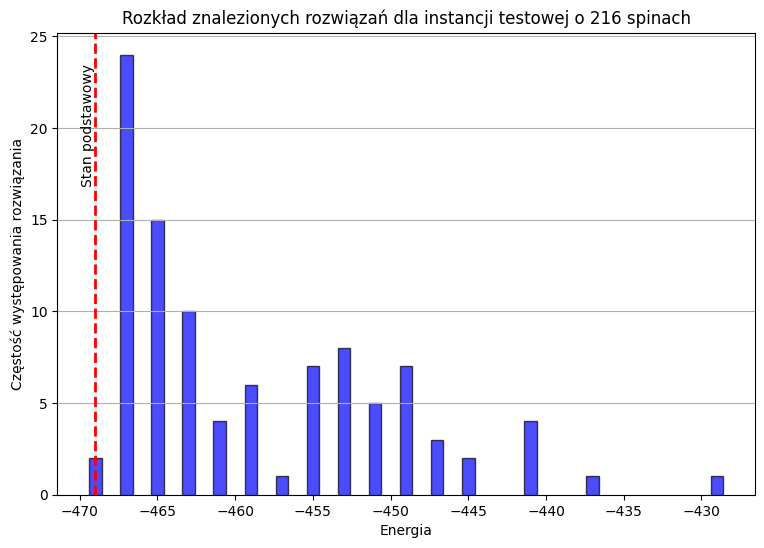

In [54]:
# Test na małym przykładzie z 216 spinami
# Balistyczna symulowana Bifurkacja

import numpy as np
import matplotlib.pyplot as plt
from funkcje_pomocnicze import read_instance, test_pegasus

J, h = read_instance(test_pegasus.path, convention="minus_half")

states, energies = discrete_simulated_bifurcation(J, h, num_steps=200, time_step=0.5, num_trajectories=100, a_0=1, c_0_scaling=0.7)

print(f"Otrzymana energia: {min(energies)}")
print(f"Stan podstawowy: {test_pegasus.best_energy}")

unique_values, counts = np.unique(energies, return_counts=True)


plt.figure(figsize=(9, 6))
plt.bar(unique_values, counts, color='blue', edgecolor='black', alpha=0.7)
#plt.xticks(energies)
plt.axvline(x=test_pegasus.best_energy, color='red', linestyle='--', linewidth=2)
plt.text(test_pegasus.best_energy, plt.ylim()[1]*0.8, 'Stan podstawowy', color='black', rotation=90,
         verticalalignment='center', horizontalalignment='right')

plt.xlabel("Energia")
plt.ylabel("Częstość występowania rozwiązania")
plt.title("Rozkład znalezionych rozwiązań dla instancji testowej o 216 spinach")
plt.grid(axis="y")
plt.show()

Zbieranie danych: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


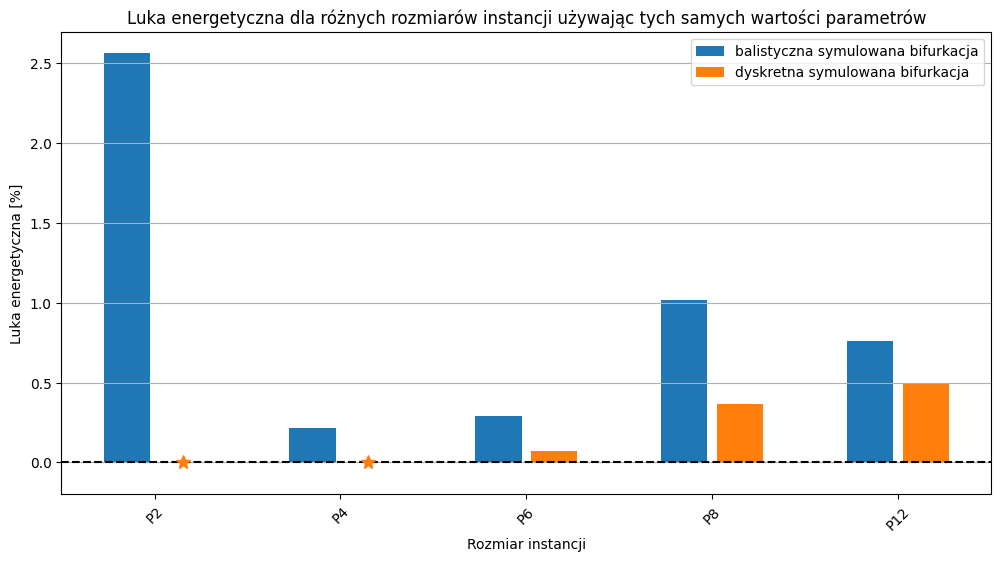

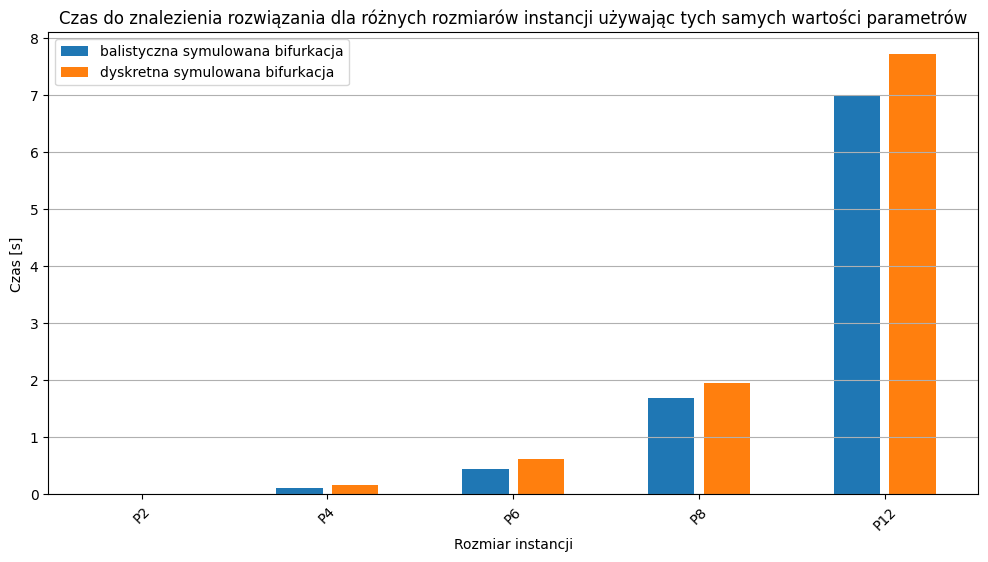

In [45]:
#  Porównanie jakości rozwiązań i czasu obliczeń dla obydwu wersji

import time
import matplotlib.pylab as plt
from funkcje_pomocnicze import read_instance, P2, P4, P6, P8, P12
from IPython.utils.io import capture_output

num_traj = 2**7
num_steps = 200
time_step = 0.75

instances = [P2, P4, P6, P8, P12]

gaps = {}
times = {}

for instance in tqdm(instances, desc="Zbieranie danych"):

    J, h = read_instance(instance.path, convention="minus_half")

    with capture_output() as captured:
        begin = time.time()
        _, energies1 = balistic_simulated_bifurcation(J, h, num_steps=num_steps, 
                                                    time_step=time_step, num_trajectories=num_traj)
        end = time.time()
        elapsed_balistic = end - begin
        
        begin = time.time()
        _, energies2 = discrete_simulated_bifurcation(J, h, num_steps=num_steps, 
                                        time_step=time_step, num_trajectories=num_traj)
        end = time.time()
        elapsed_discrete = end - begin
   
    gap_balistic = (instance.best_energy - min(energies1)) / (2*instance.best_energy) * 100
    gap_discrete = (instance.best_energy - min(energies2)) /(2*instance.best_energy) * 100

    gaps[(instance.name, "balistyczna")] = gap_balistic
    gaps[(instance.name, "dyskretna")] = gap_discrete

    times[(instance.name, "balistyczna")] = elapsed_balistic
    times[(instance.name, "dyskretna")] = elapsed_discrete

instancje = [instance.name for instance in instances]

x = np.arange(len(instancje))
width = 0.25
offset = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
barset = []
param = [-1, 1]
for idx, s in enumerate(["balistyczna", "dyskretna"]):
    a = [gaps[(i, s)] for i in instancje]
    bar = ax.bar(x + offset * param[idx], a, width, label=rf"{s} symulowana bifurkacja")
    barset.append(bar)


(y_min, y_max) = ax.get_ylim()
if y_max <1.1:
    y_max = 1.1
ax.set_ylim((-0.2, y_max))
ax.set_xlabel("Rozmiar instancji")
ax.set_xticks(x)
ax.set_xticklabels(instancje, rotation=45)
ax.set_ylabel("Luka energetyczna [%]")
ax.set_title("Luka energetyczna dla różnych rozmiarów instancji używając tych samych wartości parametrów")
ax.axhline(0, color='black', linestyle='--')

ax.legend()

for bars in barset:
    for bar in bars:
        if bar.get_height() == 0:
            center = bar.get_x() + bar.get_width()/2
            ax.plot(center, 0, marker='*', markersize=10, color=bar.get_facecolor())
plt.grid(axis="y")
plt.show()

fig2, ax2 = plt.subplots(figsize=(12, 6))
for idx, s in enumerate(["balistyczna", "dyskretna"]):
    a = [times[(i, s)] for i in instancje]
    bar = ax2.bar(x + offset * param[idx], a, width, label=rf"{s} symulowana bifurkacja")

ax2.set_xlabel("Rozmiar instancji")
ax2.set_xticks(x)
ax2.set_xticklabels(instancje, rotation=45)
ax2.set_ylabel("Czas [s]")
ax2.set_title("Czas do znalezienia rozwiązania dla różnych rozmiarów instancji używając tych samych wartości parametrów")
ax2.legend()

plt.grid(axis="y")
plt.show()

## Wpływ parametrów na zachowanie algorytmu

Skupimy się na dyskretnej symulowanej bifurkacji.

zbieranie danych: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


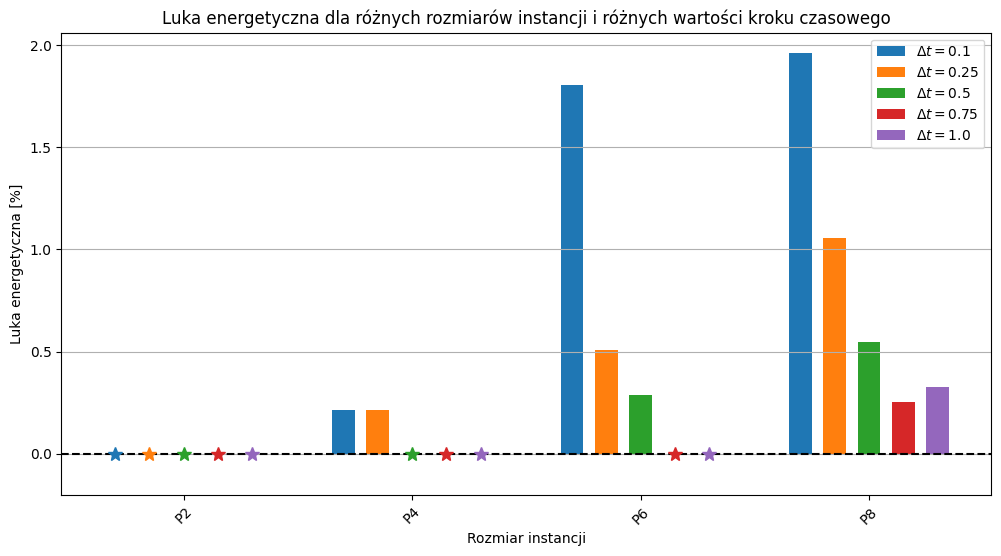

In [46]:
# krok czasowy delta t

import time
import matplotlib.pylab as plt
from funkcje_pomocnicze import read_instance, P2, P4, P6, P8
from IPython.utils.io import capture_output

num_traj = 2**7
num_steps = 200

time_steps = [0.1, 0.25, 0.5, 0.75, 1.0]
instances = [P2, P4, P6, P8]

gaps = {}
times = {}

with tqdm(total=len(instances)*len(time_steps), desc="zbieranie danych") as pbar:
    for t in time_steps:
        for instance in instances:
            J, h = read_instance(instance.path, convention="minus_half")
            with capture_output() as captured:
                begin = time.time()
                _, energies = discrete_simulated_bifurcation(J, h, num_steps=num_steps, 
                                                time_step=t, num_trajectories=num_traj)
                end = time.time()
                elapsed_discrete = end - begin

            gap = (instance.best_energy - min(energies)) / (2*instance.best_energy) * 100
            if gap < 0:
                print(instance.name, min(energies))
            gaps[(instance.name, t)] = gap
            times[(instance.name, t)] = elapsed_discrete
            pbar.update(1)

instancje = [instance.name for instance in instances]

x = np.arange(len(instancje))
width = 0.1
offset = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
barset = []
param = [-2, -1, 0, 1, 2]
for idx, s in enumerate(time_steps):
    a = [gaps[(i, s)] for i in instancje]
    bar = ax.bar(x + offset * param[idx], a, width, label=rf"$\Delta t =${s}")
    barset.append(bar)


(y_min, y_max) = ax.get_ylim()
if y_max <1.1:
    y_max = 1.1
ax.set_ylim((-0.2, y_max))
ax.set_xlabel("Rozmiar instancji")
ax.set_xticks(x)
ax.set_xticklabels(instancje, rotation=45)
ax.set_ylabel("Luka energetyczna [%]")
ax.set_title("Luka energetyczna dla różnych rozmiarów instancji i różnych wartości kroku czasowego")
ax.axhline(0, color='black', linestyle='--')

ax.legend()

for bars in barset:
    for bar in bars:
        if bar.get_height() == 0:
            center = bar.get_x() + bar.get_width()/2
            ax.plot(center, 0, marker='*', markersize=10, color=bar.get_facecolor())
plt.grid(axis="y")
plt.show()



zbieranie danych: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


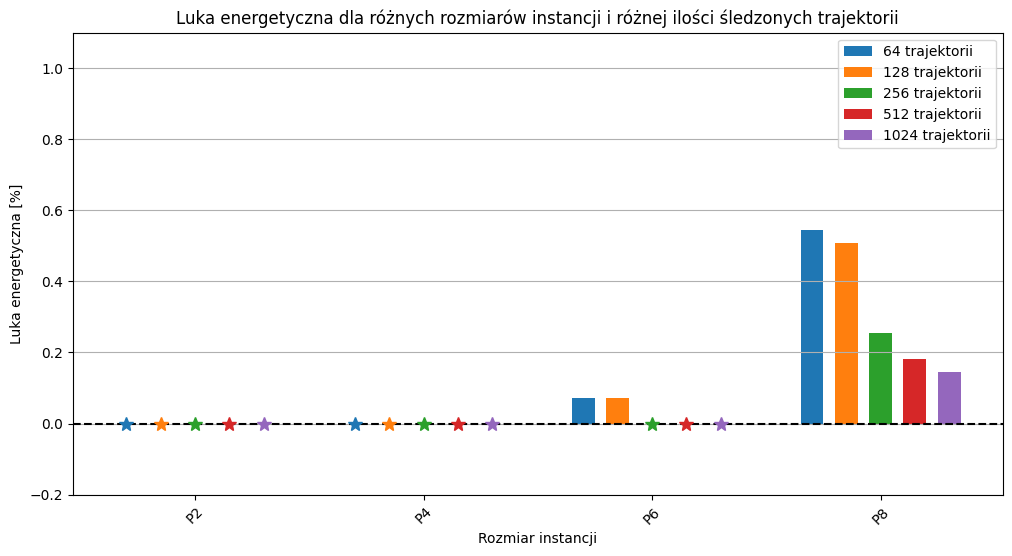

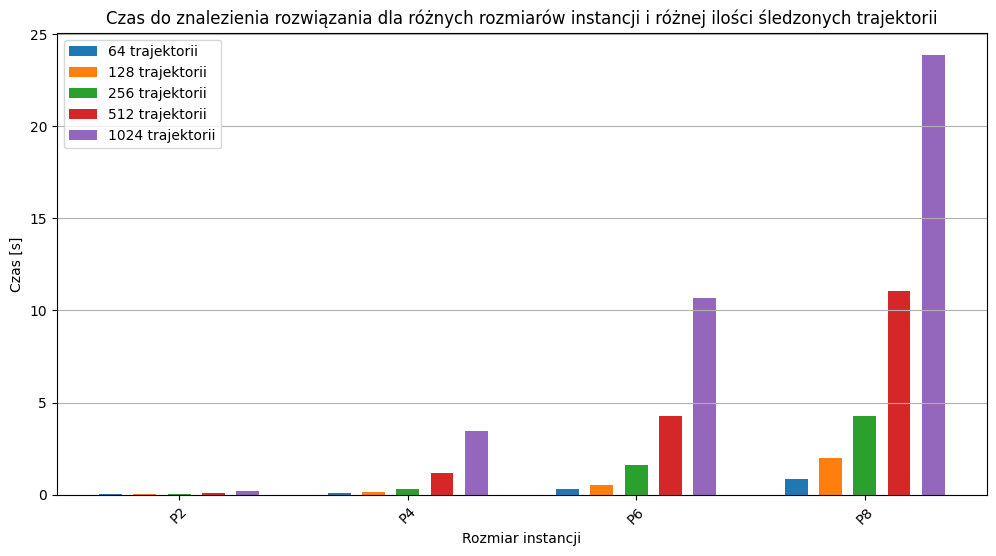

In [ ]:
# Ilość trajektorii
import matplotlib.pylab as plt
from funkcje_pomocnicze import read_instance, P2, P4, P6, P8
from IPython.utils.io import capture_output
from tqdm import tqdm

time_step = 0.75
num_steps = 200


instances = [P2, P4, P6, P8]
trajectories = [2**6, 2**7, 2**8, 2**9, 2**10]

gaps = {}
times = {}

with tqdm(total=len(instances)*len(trajectories), desc="zbieranie danych") as pbar:
    for t in trajectories:
        for instance in instances:
            J, h = read_instance(instance.path, convention="minus_half")
            with capture_output() as captured:
                begin = time.time()
                _, energies = discrete_simulated_bifurcation(J, h, num_steps=num_steps, 
                                                time_step=time_step, num_trajectories=t)
                end = time.time()
                elapsed_discrete = end - begin

            gap = (instance.best_energy - min(energies)) / (2*instance.best_energy) * 100
            if gap < 0:
                print(instance.name, min(energies))
            gaps[(instance.name, t)] = gap
            times[(instance.name, t)] = elapsed_discrete
            pbar.update(1)

instancje = [instance.name for instance in instances]

x = np.arange(len(instancje))
width = 0.1
offset = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
barset = []
param = [-2, -1, 0, 1, 2]
for idx, s in enumerate(trajectories):
    a = [gaps[(i, s)] for i in instancje]
    bar = ax.bar(x + offset * param[idx], a, width, label=rf"{s} trajektorii")
    barset.append(bar)


(y_min, y_max) = ax.get_ylim()
if y_max <1.1:
    y_max = 1.1
ax.set_ylim((-0.2, y_max))
ax.set_xlabel("Rozmiar instancji")
ax.set_xticks(x)
ax.set_xticklabels(instancje, rotation=45)
ax.set_ylabel("Luka energetyczna [%]")
ax.set_title("Luka energetyczna dla różnych rozmiarów instancji i różnej ilości śledzonych trajektorii")
ax.axhline(0, color='black', linestyle='--')

ax.legend()

for bars in barset:
    for bar in bars:
        if bar.get_height() == 0:
            center = bar.get_x() + bar.get_width()/2
            ax.plot(center, 0, marker='*', markersize=10, color=bar.get_facecolor())
plt.grid(axis="y")
plt.show()

fig2, ax2 = plt.subplots(figsize=(12, 6))
for idx, s in enumerate(trajectories):
    a = [times[(i, s)] for i in instancje]
    bar = ax2.bar(x + offset * param[idx], a, width, label=rf"{s} trajektorii")

ax2.set_xlabel("Rozmiar instancji")
ax2.set_xticks(x)
ax2.set_xticklabels(instancje, rotation=45)
ax2.set_ylabel("Czas [s]")
ax2.set_title("Czas do znalezienia rozwiązania dla różnych rozmiarów instancji i różnej ilości śledzonych trajektorii")
ax2.legend()

plt.grid(axis="y")
plt.show()

zbieranie danych: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


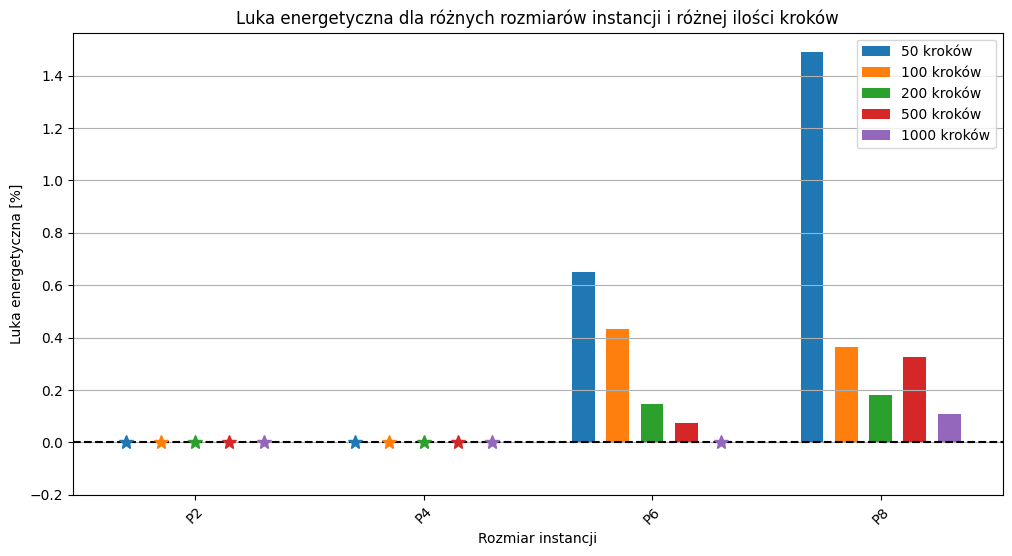

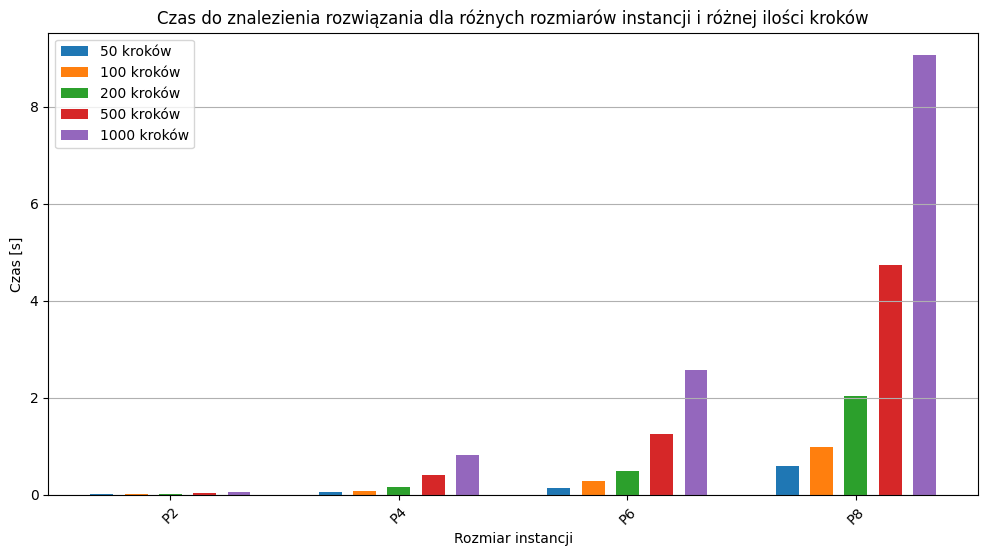

In [47]:
# Ilość kroków

import matplotlib.pylab as plt
from funkcje_pomocnicze import read_instance, P2, P4, P6, P8
from IPython.utils.io import capture_output
from tqdm import tqdm

time_step = 0.75
num_trajectories = 2**7


instances = [P2, P4, P6, P8]
steps = [50, 100, 200, 500, 1000]

gaps = {}
times = {}

with tqdm(total=len(instances)*len(steps), desc="zbieranie danych") as pbar:
    for t in steps:
        for instance in instances:
            J, h = read_instance(instance.path, convention="minus_half")
            with capture_output() as captured:
                begin = time.time()
                _, energies = discrete_simulated_bifurcation(J, h, num_steps=t, 
                                                time_step=time_step, num_trajectories=num_trajectories)
                end = time.time()
                elapsed_discrete = end - begin

            gap = (instance.best_energy - min(energies)) / (2*instance.best_energy) * 100
            if gap < 0:
                print(instance.name, min(energies))
            gaps[(instance.name, t)] = gap
            times[(instance.name, t)] = elapsed_discrete
            pbar.update(1)

instancje = [instance.name for instance in instances]

x = np.arange(len(instancje))
width = 0.1
offset = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
barset = []
param = [-2, -1, 0, 1, 2]
for idx, s in enumerate(steps):
    a = [gaps[(i, s)] for i in instancje]
    bar = ax.bar(x + offset * param[idx], a, width, label=rf"{s} kroków")
    barset.append(bar)


(y_min, y_max) = ax.get_ylim()
if y_max <1.1:
    y_max = 1.1
ax.set_ylim((-0.2, y_max))
ax.set_xlabel("Rozmiar instancji")
ax.set_xticks(x)
ax.set_xticklabels(instancje, rotation=45)
ax.set_ylabel("Luka energetyczna [%]")
ax.set_title("Luka energetyczna dla różnych rozmiarów instancji i różnej ilości kroków")
ax.axhline(0, color='black', linestyle='--')

ax.legend()

for bars in barset:
    for bar in bars:
        if bar.get_height() == 0:
            center = bar.get_x() + bar.get_width()/2
            ax.plot(center, 0, marker='*', markersize=10, color=bar.get_facecolor())
plt.grid(axis="y")
plt.show()

fig2, ax2 = plt.subplots(figsize=(12, 6))
for idx, s in enumerate(steps):
    a = [times[(i, s)] for i in instancje]
    bar = ax2.bar(x + offset * param[idx], a, width, label=rf"{s} kroków")

ax2.set_xlabel("Rozmiar instancji")
ax2.set_xticks(x)
ax2.set_xticklabels(instancje, rotation=45)
ax2.set_ylabel("Czas [s]")
ax2.set_title("Czas do znalezienia rozwiązania dla różnych rozmiarów instancji i różnej ilości kroków")
ax2.legend()

plt.grid(axis="y")
plt.show()

# Bibliografia

* Hayato Goto *et al.*, Combinatorial optimization by simulating adiabatic bifurcations in nonlinear Hamiltonian systems. *Sci. Adv.* **5**, eaav2372 (2019). DOI:[10.1126/sciadv.aav2372](https://www.science.org/doi/10.1126/sciadv.aav2372)

* Hayato Goto *et al.*, High-performance combinatorial optimization based on classical mechanics. *Sci. Adv.* **7**, eabe7953 (2021).   
DOI:[10.1126/sciadv.abe7953](https://www.science.org/doi/10.1126/sciadv.abe7953)